In [9]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import jinja2

reading the dataset

In [10]:
def read_csv(file_path,has_header):
    """this function is used for taking the dataset from .csv file making a test train split
    and x, y split (has header is either True or False)"""

    #reading the .csv
    if has_header:
        df = pd.read_csv(file_path, header=0, delimiter=",")  # First row as header
        print(f"Dataset shape: {df.shape}")
        print(f"Column names: {list(df.columns)}")
    else:
        df = pd.read_csv(file_path, header=None, delimiter=",")  # No header row
        print(f"Dataset shape: {df.shape}")
    
    return df


selecting the dataset

dataset_name= "beans"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 16
number_of_sets = 4

In [11]:
dataset_name= "diabetes"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 8
number_of_sets = 3

Dataset shape: (768, 9)
Column names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


dataset_name= "divorce"
df = read_csv(dataset_name + ".csv", True)
label_column = 54
number_of_sets = 14

dataset_name= "parkinsons"
df = read_csv(dataset_name + "_kmeans.csv", True)
df = df.drop(columns = 'name')
label_column = 17
number_of_sets = 6

dataset_name= "rice"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
label_column = 7
number_of_sets = 2

dataset_name= "wdbc"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
df = df.drop(columns = 'ID')
label_column = 0
number_of_sets = 8

making string columns numeric

In [12]:
# Find all string/object columns automatically
string_columns = df.select_dtypes(include=['object']).columns

# Encode all string columns
for column in string_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])

mi for all features (graph)

In [13]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


                    Feature  MI_Score
1                   Glucose  0.188579
5                       BMI  0.090431
7                       Age  0.082317
4                   Insulin  0.059904
0               Pregnancies  0.047912
3             SkinThickness  0.043158
6  DiabetesPedigreeFunction  0.033205
2             BloodPressure  0.027568


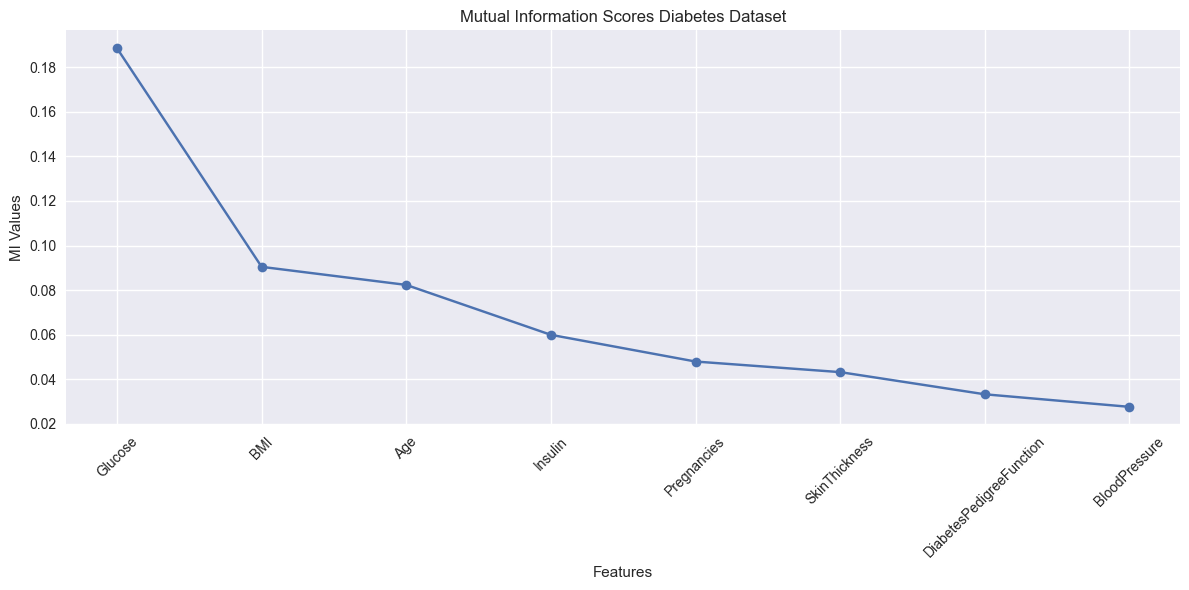

In [14]:
def mi_for_all(df_name = df, lc = label_column, title = 'complete dataset'):
    y = df_name.iloc[:, lc]
    x = df_name.drop(df_name.columns[lc], axis=1)
    mi_scores = mutual_info_classif(x, y, discrete_features=True)
    mi_scores= mi_scores / np.log(2)
    mi_df = pd.DataFrame({"Feature": x.columns, "MI_Score": mi_scores}).sort_values(by="MI_Score", ascending=False)
    print(mi_df)

    # Create line plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(mi_df["Feature"], mi_df["MI_Score"], marker='o')
    ax.set_xlabel("Features")
    ax.set_ylabel("MI Values")
    ax.set_title(f"Mutual Information Scores {dataset_name.title()} Dataset")
    plt.style.use('seaborn-v0_8')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'mi {dataset_name} {title}.png', dpi=300, bbox_inches='tight')
    plt.show()


    return x,y,mi_df

x,y,mi_df= mi_for_all()
mi_df.to_latex(f'{dataset_name}_mi.tex', index=True, float_format='%.6f')



vertical split

In [15]:
# Target columns count (divide into 3 parts, take integer)
#total_columns = df.shape[1]
#target_columns_count = total_columns // 3
# Pick random feature columns from total number of columns from dataset x
#random.seed(42)
#random_cols = random.sample(range(x.shape[1]), target_columns_count - 1)
# Build target_set (label first, then random features)
#target_features = x.iloc[:, random_cols]
#target_set = pd.concat([y, target_features], axis=1)
#remaining_set = x.drop(x.columns[random_cols], axis=1)
#print("Target columns count:", target_columns_count)
#print("Selected feature indices:", random_cols)
#print(target_set.head(), "\n")
#print(remaining_set.head())

# Split the feature indices into groups
parts = np.array_split(np.arange(df.shape[1]), number_of_sets, axis=0)

# Get the first group of feature indices
#target_feature_indices = parts[0]

# Select the target features using column indices
#target_features = x.iloc[:, target_feature_indices]

# Create target set by concatenating y with target features
#target_set = pd.concat([y, target_features], axis=1)
print("Parts:")
for i, part in enumerate(parts):
    print(f"Part {i}: {part}")

target_set = None

# Find which part has the label column and get that part
for part in parts:
    if label_column in part:
        target_set = df.iloc[:, part]
        break

if target_set is not None:
    print(f"Target set shape: {target_set.shape}")
else:
    print(f"Label column {label_column} not found in any part")



#make label first column on target_set and the last column will be the lowst mi on target_set
label_col = df.columns[label_column]
col_data = target_set.pop(label_col)  # Remove the column
target_set.insert(0, label_col, col_data)  # Insert it at position 0


# Create remaining set by dropping the target feature columns
#remaining_set = x.drop(x.columns[target_feature_indices], axis=1)

#print("Selected feature indices:", target_feature_indices)

#print("Remaining set shape:", remaining_set.shape)
#print(remaining_set.head())


Parts:
Part 0: [0 1 2]
Part 1: [3 4 5]
Part 2: [6 7 8]
Target set shape: (768, 3)


mi on the set with label to find the target (lowest mi)

                    Feature  MI_Score
1                       Age  0.082317
0  DiabetesPedigreeFunction  0.033205


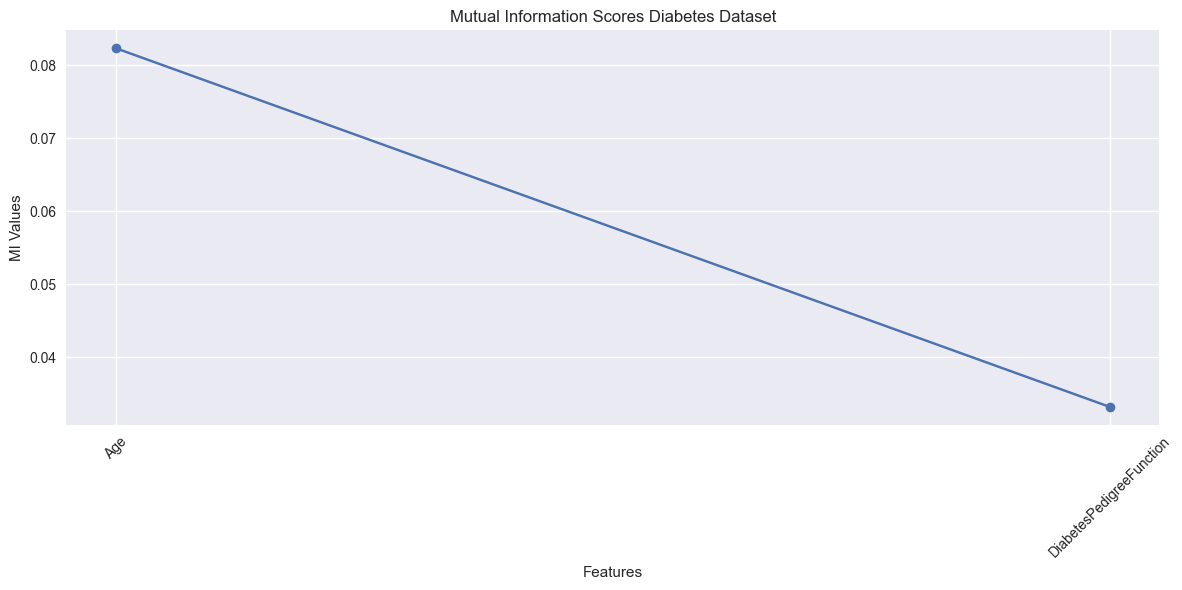

Column with lowest MI: DiabetesPedigreeFunction
lowest_mi_data:0      2.0
1      1.0
2      2.0
3      0.0
4      9.0
      ... 
763    0.0
764    1.0
765    0.0
766    1.0
767    1.0
Name: DiabetesPedigreeFunction, Length: 768, dtype: float64
x:     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
0              3        6              5              5        0  4.0   
1              0        2              5              4        0  2.0   
2              4        8              5              0        0  1.0   
3              0        2              5              4        1  2.0   
4              0        6              2              5        2  6.0   
..           ...      ...            ...            ...      ...  ...   
763            5        3              6              7        2  4.0   
764            1        5              5              4        0  5.0   
765            2        5              5              4        1  2.0   
766            0        

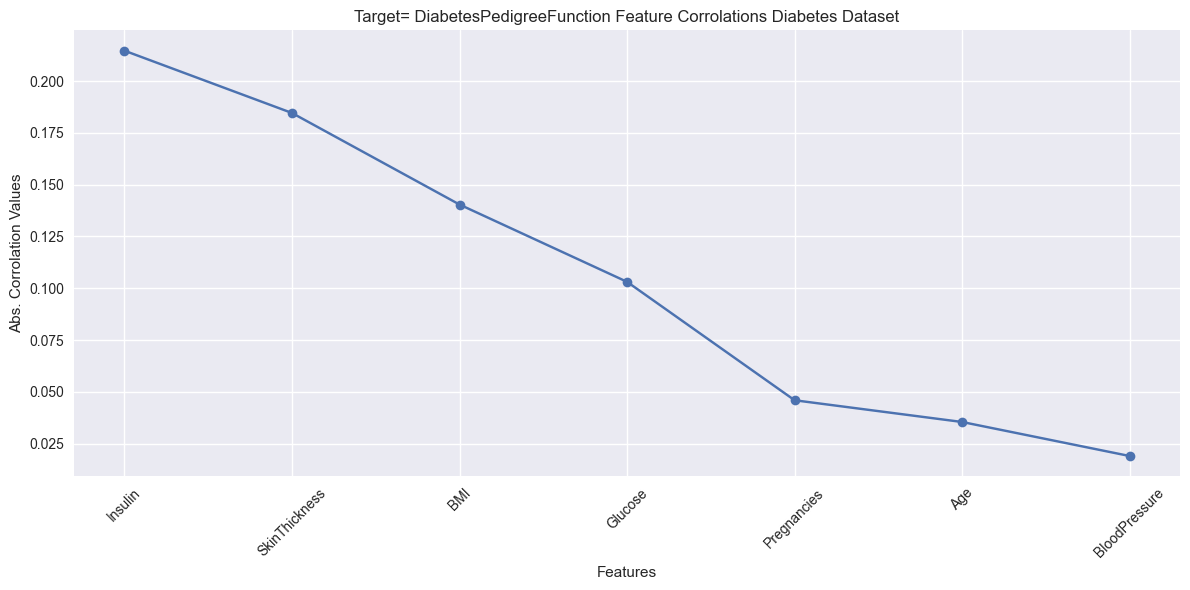

In [16]:
# Get MI scores and find lowest MI column
a,b,target_mi_df = mi_for_all(df_name=target_set, lc=0, title = 'in target set')

lowest_mi_column = target_mi_df.iloc[-1]['Feature']
print(f"Column with lowest MI: {lowest_mi_column}")

# Calculate Spearman correlations
lowest_mi_data = target_set[lowest_mi_column]
print(f"lowest_mi_data:{lowest_mi_data}")
print(f"x:{x}")
#x_ranked = x.rank(method='average').astype(int)
#lowest_mi_ranked = lowest_mi_data.rank(method='average').astype(int)
correlations = x.corrwith(lowest_mi_data, method='spearman')

# Convert to DataFrame and sort
corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Spearman_Correlation': correlations.abs().values
}).sort_values('Spearman_Correlation', ascending=False)

# Remove the column that correlates with itself
corr_df = corr_df[corr_df['Feature'] != lowest_mi_column]

print(f"Spearman correlations between '{lowest_mi_column}' and x:")
print(corr_df)

# Create line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(corr_df["Feature"], corr_df["Spearman_Correlation"], marker='o')
ax.set_xlabel("Features")
ax.set_ylabel("Abs. Corrolation Values")
ax.set_title(f"Target= {lowest_mi_column} Feature Corrolations {dataset_name.title()} Dataset")
plt.style.use('seaborn-v0_8')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{dataset_name} spearman correlation.png', dpi=300, bbox_inches='tight')
plt.show()

corr_df.to_latex(f'{dataset_name}_corr.tex', index=True, float_format='%.6f')

spearman with target to varibales that are outside the set (graph to see elbow)